# hurricane-net
Hammad Usmani
### A machine learning algorithm to forecast the intensity and trajectory of Atlantic tropical storms
[https://github.com/hammad93/hurricane-net](https://github.com/hammad93/hurricane-net)

### Table of Contents

1. [Background](#Background)
2. [Problem](#Problem)
3. [Datasets](#Datasets)
4. [Workflow Diagram](#Workflow)
5. [Data Extraction](#Extract)
6. [Data Transformation](#Transform)
7. [Data Loading](#Load)
8. [Feature Engineering](#FeatureEngineering)
9. [Model Architecture](#ModelArchitecture)
11. [Model Selection](#ModelSelection)
12. [Paramater Optimization](#Optimization)
13. [Model Evaluation & Benchmarks](#Benchmarks)
14. [Visualizations](#Visualizations)

![Hurricane Maria 2017](img/hurricane-maria.png "Hurricane Maria. Source: NOAA")

## Background<a id="Background"></a>

The National Hurricane Center (NHC) and National Oceanic and Atmospheric Administration (NOAA) provide predictions for storms trajectories, intensity, and size. They create these predictions based on models that can be classified into 3 groups: dynamical, statistical, and ensemble [1]. The most accurate models are based on computational fluid dynamics and achieve more precision than their statistical and ensemble counterparts [1][4]. The current statistical models (OCD5) are based on multiple regression methods that can explain a significant amount of variance [1]. In this project, we research and implement the domain of machine learning and deep learning into predictive hurricane models for both trajectory and intensity and evaluate them against the NHC standards. 
Previous research into machine learning to forecast tropical Atlantic storms include a sparse recurrent neural network (Kordmahalleh, Sefidmazgi, & Homaifar, 2016) and an artificial neural network (Jung & Das, 2013); both achieved favorable results. The hurricane models created can be utilized to develop more precise emergency planning. There is a necessity for more accurate and timely models that can help reduce the amount of loss caused by hurricanes. 

## Problem<a id="Problem"></a>

The NOAA and NHC have several different classifications for Atlantic hurricane models that describe feature prediction and model architecture. The 3 main classifications for hurricane model architecture include dynamical, statistical, and ensemble. Classifications also include relative compute time required to create an output grouped as either early or late and forecast parameters such as trajectory, intensity, and wind radii. The most accurate models are late models that take upwards of 6 hours to produce an output whereas models that can produce an output in seconds to minutes are called early. Early models tend to be statistical which include the baseline model for trajectory named CLIPER5 Climatology and Persistence (CLP5) utilizing multivariate regression. The performance for these methods can be augmented by incorporating more advanced statistical methods from deep learning such as recurrent neural networks. Kordmahalleh et al., 2016 created a sparse recurrent neural network augmented by a genetic algorithm but there are factors requiring improvement. The training set utilized an older version of the NHC Hurricane Database format known as HURDAT while a new format has been released called HURDAT2 with additional information on wind radii. Kordmahalleh et al., 2016 also utilized benchmarks different from the standard applied within the NHC. Other than improving their methodology, we can expand the scope by creating separate models for both intensity and trajectory. These models can be used to predict the trajectory and intensity for future Atlantic storms.

## Datasets<a id="Datasets"></a>

The following datasets and inputs including their sources will be used to create machine learning models:
- NHC Hurricane Database (HURDAT2)
    - http://www.nhc.noaa.gov/data/#hurdat
    - https://www.kaggle.com/noaa/hurricane-database
- NHC Forecast Error Database
    - http://www.nhc.noaa.gov/verification/verify7.shtml
- NHC GIS
    - http://www.nhc.noaa.gov/gis/
    
The NHC HURDAT2 database contains the tracking information for Atlantic tropical and subtropical cyclones which includes hurricanes and tropical storms from 1851 to 2016. The most updated version of the dataset is included on the noaa.gov site and includes 2 additional years of cyclone data compared to the data set available on Kaggle and is potentially more descriptive. To match the inputs of the baseline model used by the NHC, we are calculating the forward motion of the storm by applying a vector based on previous and current geographical location.

*Table 1. This table contains the tentative features as input to the model*

| **Name**         | **Data Type** | **Description**                                                     |
|------------------|---------------|---------------------------------------------------------------------|
| Time             | Date Time     | The date and time of the measurement.                               |
| Latitude         | Float         | The geographical latitude of the storm eye to 1 decimal precision.  |
| Longitude        | Float         | The geographical longitude of the storm eye to 1 decimal precision. |
| Maximum Winds    | Integer       | The maximum sustained winds within the storm.                       |
| Minimum Pressure | Integer       | The minimum barometric pressure within the storm.                   |
| Forward Motion   | String        | Calculated vector of motion based on location in time series.       |

The Forecast Error Database contains information on the accuracy of predicted models from the NHC. The two model forecast errors available are labeled OFCL and BCD5. The OFCL is the official NHC forecast and the BCD5 is the real track available. This data set can be used to benchmark and evaluate the deep learning model. 
The NOAA and NHC also hosts a geographical information system (GIS) that contains raw and processed data on hurricanes. The server hosting the GIS is publicly accessible and can be used to evaluate our model by comparing the 2017 Atlantic tropical season. The preliminary best tracks can be found here before they are finalized and available in the HURDAT2 data set. With the GIS, we can construct a final evaluation data set.

*Diagram 1. This graphic describes the workflow for the deep learning models*.<a id="Workflow"></a>
![Data Pipeline](img/Deep Learning Workflow.png "hurricane-net Data Pipeline")

## Extract Data<a id="Extract"></a>

*The following code uses the hurdat2 and models modules created to provide a class interface for the HURDAT2 and error forecast database located in the data and models folder. *

We will begin our steps to perform extraction, transformation, and loading of our data for analysis or broadly known as ETL. Although we're dividing these steps into disctinct procedures, they are often more fluid and often have overlaps. The extraction phase consists of collecting and parsing the HURDAT2 and error forecast databases for analysis and benchmarking. The HURDAT2 database is our core foundation for creating the deep learning model. We store the database in its raw .txt format but it can be directly linked to the database hosted by the NHC.

In [1]:
# Import various libraries throughout the software
from pprint import pprint
import numpy as np
import datetime
import dateutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# Import from hurdat2 class in data folder and models class from hurricane-models folder
from data.hurdat2 import hurdat2
from errors.models import models

# Initialize Dataframe for hurricanes and error database
dataset = hurdat2("data/hurdat2.txt")
errors = models("errors/1970-present_OFCL_v_BCD5_ind_ATL_TI_errors_noTDs.txt")

# Show the first 5 records from Hurricane Katrina 2005 (AL122005)
dataset.hurricanes.query('storm_id == "AL122005"').head()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


,storm_id,storm_name,entry_time,entry_id,entry_status,lat,long,max_wind,min_pressure,34kt_ne,...,34kt_sw,34kt_nw,50kt_ne,50kt_se,50kt_sw,50kt_nw,64kt_ne,64kt_se,64kt_sw,64kt_nw
44063,AL122005,KATRINA,2005-08-23 18:00:00,,TD,23.1N,75.1W,30,1008,0,...,0,0,0,0,0,0,0,0,0,0
44064,AL122005,KATRINA,2005-08-24 00:00:00,,TD,23.4N,75.7W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44065,AL122005,KATRINA,2005-08-24 06:00:00,,TD,23.8N,76.2W,30,1007,0,...,0,0,0,0,0,0,0,0,0,0
44066,AL122005,KATRINA,2005-08-24 12:00:00,,TS,24.5N,76.5W,35,1006,60,...,0,0,0,0,0,0,0,0,0,0
44067,AL122005,KATRINA,2005-08-24 18:00:00,,TS,25.4N,76.9W,40,1003,60,...,0,0,0,0,0,0,0,0,0,0


In [2]:
# Show the first 3 OFCL hurricane model errors for Hurricane Katrina 2005 on 28-08-2005/18:00:00
pprint(errors.models['OFCL'].storm['AL122005'][datetime.datetime(2005, 8, 28, 18, 0)], indent = 8)

{       'intensity_forecast': {       datetime.datetime(2005, 8, 28, 18, 0): 0.0,
                                      datetime.datetime(2005, 8, 29, 6, 0): 20.9,
                                      datetime.datetime(2005, 8, 29, 18, 0): 93.6,
                                      datetime.datetime(2005, 8, 30, 6, 0): 170.2,
                                      datetime.datetime(2005, 8, 30, 18, 0): None,
                                      datetime.datetime(2005, 8, 31, 18, 0): None,
                                      datetime.datetime(2005, 9, 1, 18, 0): None,
                                      datetime.datetime(2005, 9, 2, 18, 0): None,
                                      datetime.datetime(2005, 9, 3, 18, 0): None,
                                      datetime.datetime(2005, 9, 4, 18, 0): None},
        'lat': 26.3,
        'long': 88.6,
        'sample_sizes': {       'F012': 0.33,
                                'F024': 0.33,
                                'F036': 

## Transform Data<a id="Transform"></a>

The following code will tranform the hurricane best path data into objects that can be better manipulated for processing. to match between datasets, we will also create a `storm_id` dictionary to store storm names matched with ID's.

In [3]:
# Create hurricane class
class hurricane(object) : 
    def __init__(self, name, id) :
        # Set instance variables
        self.name = name
        self.id = id
        self.entries = dict()
        self.models = dict()
        
        return
    # Add hurricane track entry based on standard HURDAT2 format
    def add_entry(self, array) :
        entry = {
            array[0] : { # dateteime of entry
                'entry_time' : array[0], 
                'entry_id' : array[1],
                'entry_status' : array[2],
                'lat' : float(array[3][:-1]), # Convert to number from format '#.#N'
                'long' : float(array[4][:-1]), # Convert to number from format '#.#W'
                'max_wind' : float(array[5]),
                'min_pressure' : None if array[6] is None else float(array[6]), # Early records are -999 or None
                'wind_radii' :  array[7:], # Array based on HURDAT2 format
            }
        }
        self.entries.update(entry)
        
        return
    # Add hurricane model errors
    def add_model(self, name, model) :
        self.models[name] = model
        
        return
# Storm ID Key for matching between datasets
storm_id = dict()

# Parse in hurricanes
hurricanes = dict()
print("Transforming HURDAT2 into objects . . .")
for index, entry in dataset.hurricanes.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset.hurricanes)), end = "\r")
    # New hurricane
    if entry['storm_id'] not in hurricanes :
        hurricanes[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_id[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes[entry['storm_id']].add_entry(entry[2:])
print("\nDone!")

Transforming HURDAT2 into objects . . .
Transforming 49691/49691 entries from HURDAT2
Done!


## Load Data<a id="Load"></a>

The following will finalize our preliminary data preparation by loading some of the errors into each hurricane object. Note that models start from the year 1970 and any hurricane before that has no previous model data.

In [4]:
# Get all available model errors
models = errors.models.keys()
# Load model errors into hurricanes
for id in storm_id :
    for model in models :
        # Skip if this hurricane does not have the model
        if id not in errors.models[model].storm :
            continue
        hurricanes[id].add_model(model, errors.models[model].storm[id])

## Feature Engineering & Data Augmentation<a id="FeatureEngineering"></a>

The following section will extract the relevant features and engineer each data point so that we can fit it into the model. Because the type of inputs are important, the features will be transformed based on the model architecture. This will also include data augmentation methods. The higher level architecture will be a deep learning recurrent neural network with LSTM and time distributed layers.

The current statistical baseline model using multivariate regression uses multiple predictors as input. According to Knaff 2013, the following predictors were calculated for their intensity model that were not included in the HURDAT2 database. These features can be calculated from the data loaded into our current object model.

1. Date Information
2. Zonal Speed Of The Storm (U) (kt)
3. Meridional Speed Of The Storm (V) (kt)
4. 12-h Change In Intensity (DVMX) (kt)

The shape on the input to the LSTM will be in a 3D array with the format [samples, timestamps, features]. We will intitially begin with 1 time step and evaluate more can benefit our model. The output requires a 5 day forecast and observations without track data 5 days in the future will not be used.

In [5]:
def feature_extraction(timestep, previous) :
    '''
    PURPOSE: Calculate the features for a machine learning model within the context of hurricane-net
    METHOD: Use the predictors and the calculation methodology defined in Knaff 2013
    INPUT:  timestep - current dictionary of features in the hurricane object format
            previous - previous timestep dictionary of features in the hurricane object format
    OUTPUT: Dictionary of features
    '''
    features = {
        'lat' : timestep['lat'],
        'long' : timestep['long'],
        'max_wind' : timestep['max_wind'],
        'delta_wind' : (timestep['max_wind'] - previous['max_wind']) / # Calculated from track (12h)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'min_pressure' : timestep['min_pressure'], 
        'zonal_speed' : (timestep['lat'] - previous['lat'])/ # Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'meridonal_speed' : (timestep['long'] - previous['long'])/# Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'year' : timestep['entry_time'].year,
        'month' : timestep['entry_time'].month,
        'day' : timestep['entry_time'].day,
        'hour' : timestep['entry_time'].hour,
    }
    return features
    
def storm_x_y(storm, timesteps = 1, lag = 24) :
    '''
    PURPOSE: Create independent and dependent samples for a machine learning model based on the timesteps
    METHOD: Use the HURDAT2 database and a hurricane object as defined in hurricane-net for feature extraction
    INPUT:  storm - hurricane object
            timesteps - (default = 1) number of timesteps to calculate
            include_none - (default = False) Boolean for including None in test data. Imputing function unavailable.
            lag - (default = 24) lag in hours for the dependent variables up to 5 days
    OUTPUT: Dictionary with independent (x) and dependent (y) values.
    '''
    x = []
    # Create testing data structure with a dictionary
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    y = dict([(time,[]) for time in times])
    
    # Sort by entry time
    entries = [entry[1] for entry in sorted(storm.entries.items())]
    
    for index in range(len(entries)) :
        if index < timesteps : # Flag for insufficient initial time steps
            continue

        # If we're not including None values, check to see if there will be any
        if None in [storm.entries.get(entries[index]['entry_time'] +
                                         datetime.timedelta(hours = future)) for future in times] : break
            
        # Calculate time steps and their features for independent values
        sample = []
        for step in range(timesteps) :
            # Training sample
            timestep = entries[index - step]
            previous = entries[index - step - 1]
            sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
        x.append(sample) # Add our constructed sample
        
        # Calculate time steps and their features for dependent values
        for future in times :
            timestep = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future))
            previous = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future - lag))
            
            if timestep and previous: 
                y[future].append(feature_extraction(timestep, previous))
            else :
                y[future].append(None)
    
    # Return output, if there is no output, return None.
    if len(x) is 0 :
        return None
    else:
        return {'x': x, 'y': y}
def shape(hurricanes, timesteps, remove_missing = True) :
    '''
    PURPOSE: Shape our data for input into machine learning models
    METHOD: Use a numpy array to shape into (samples, timesteps, features)
    INPUT:  hurricanes - dictionary of hurricane objects
            timesteps - number of timesteps for the shape
            remove_missing - boolean indicating whether the algorithm will disregard missing values
    OUTPUT: numpy array of shape (samples, timesteps, 8) where 8 is the number of predictors in a hurricane object
    '''
    x = []
    y = []
    lag = 24 # lag time in hours
    precision = np.float64 # defines the precision of our data type
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    count = 0
    for hurricane in hurricanes.values() :
        count += 1
        result = storm_x_y(hurricane, timesteps, lag)
        if result is None :
            continue
        # Extract only the values from the strom features using our specified precision
        hurricane_x = np.array(
            [[list(sample[1][0].values()) for sample in x] for x in result['x']],
            dtype = precision)
        hurricane_y = np.array(
            [[list(result['y'][time][index].values()) for time in times] for index in range(len(result['y'][lag]))],
            dtype = precision)
        # Disregard if algorithm requires no missing values
        if remove_missing :
            if (len(np.where(np.isnan(hurricane_x))[0]) > 0) or (len(np.where(np.isnan(hurricane_y))[0]) > 0) :
                continue
        # Add to our results
        x.extend(hurricane_x)
        y.extend(hurricane_y)
        print("Feature engineered {}/{} hurricanes for {} timestep(s)".format(count, len(hurricanes), timesteps), end = "\r")
    print("\nDone feature engineering hurricanes.")
    
    return {'x': np.array(x), 'y': np.array(y)}
def scaler(processed_data, hurricanes) :
    '''
    PURPOSE: Scale our data using the RobustScaler method from the sklearn library
    METHOD: Generate data using 1 timesteps and then remove the NaN or None types to use the scaler methods
    INPUT:  hurricanes - dictionary of hurricane objects
            processed_data - dictionary of x and y values of data produced by shape() function with no missing values
    OUTPUT: 1) Scaled processed_data using RobustScaler
            2) RobustScaler object fit with appropriate data
    '''
    print("Scaling Data . . . (1 timestep for unqiue data)")
    # Create our scaler
    unqiue_data = shape(hurricanes, timesteps = 1)
    x = np.reshape(unqiue_data['x'], (unqiue_data['x'].shape[0], -1))
    x = np.delete(x, np.where(np.isnan(x))[0], 0)
    scaler = RobustScaler()
    scaler.fit(x)
    
    # Scale our data
    for index in range(len(processed_data['x'])) :
        # Scale our x
        processed_data['x'][index] = scaler.transform(processed_data['x'][index])
        # Scale our y
        processed_data['y'][index] = scaler.transform(processed_data['y'][index])
    print("Done scaling.")
    return processed_data, scaler
# Finalize and scale procesed data into a dictionary
preprocessed_data = shape(hurricanes, timesteps = 5)
processed_data, scaler = scaler(preprocessed_data, hurricanes)

Feature engineered 1830/1830 hurricanes for 5 timestep(s)
Done feature engineering hurricanes.
Scaling Data . . . (1 timestep for unqiue data)
Feature engineered 1830/1830 hurricanes for 1 timestep(s)
Done feature engineering hurricanes.
Done scaling.


## Model Architecture<a id="ModelArchitecture"></a>

Following feature engineering, we are now ready to input our data into a machine learning algorithm. The scope of this project will attempt a deep learning approach to forecasting Atlantic tropical cyclones. We will experiment with nunermous different architectures but we will focus around a Recurrent Neural Network utilizing LSTM cells.

Notes:
- We will use 500 epochs for wind intensity because the validation loss is not decresing
- We will use 1,000 epochs for latitute and longitude

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from sklearn import model_selection

# Create our cross validation data structure
X_train, X_test, y_train, y_test = model_selection.train_test_split(processed_data['x'], processed_data['y'],
                                                                    test_size = 0.2)

# Train for wind intensity
y_train_wind = np.array([[[features[2]] for features in y] for y in y_train], dtype = np.float64)
y_test_wind = np.array([[[features[2]] for features in y] for y in y_test], dtype = np.float64)

# Train for latitude and longitude location
y_train_lat = np.array([[[features[0]] for features in y] for y in y_train], dtype = np.float64)
y_test_lat = np.array([[[features[0]] for features in y] for y in y_test], dtype = np.float64)
y_train_long = np.array([[[features[1]] for features in y] for y in y_train], dtype = np.float64)
y_test_long = np.array([[[features[1]] for features in y] for y in y_test], dtype = np.float64)


def bd_lstm_td(X_train, y_train, X_test, y_test, n_epochs = 500) :    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 1024, return_sequences = True, dropout = 0.05),
                            input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(units = 512, return_sequences = True, dropout = 0.05))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mae', optimizer='adam')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

def lstm_td(X_train, X_test, y_train, y_test) :
    model = Sequential()
    model.add(LSTM(units = 1024, input_shape = (5,8), return_sequences = True))
    model.add(TimeDistributed(Dense(8)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    model.fit(X_train, y_train, batch_size = len(X_train), epochs = 300)
    
    return model

model_wind, model_wind_history = bd_lstm_td(X_train, y_train_wind, X_test, y_test_wind)
model_lat, model_lat_history = bd_lstm_td(X_train, y_train_lat, X_test, y_test_lat, n_epochs = 1000)
model_long, model_long_history = bd_lstm_td(X_train, y_train_long, X_test, y_test_long, n_epochs = 1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 5, 2048)           8486912   
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 512)            5244928   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 1)              513       
Total params: 13,732,353
Trainable params: 13,732,353
Non-trainable params: 0
_________________________________________________________________
None
Train on 3298 samples, validate on 825 samples
Epoch 1/500
3298/3298 [==============================] - 3s 1ms/step - loss: 0.7135 - val_loss: 0.6226
Epoch 2/500
3298/3298 [==============================] - 1s 304us/step - loss: 0.6116 - val_loss: 0.6060
Epoch 3/500
3298/3298 [==============================] - 1s 305us/step - loss: 0.5923 - val_loss: 0.5785
Epoch 4/500
3298/3298 [======

Epoch 71/500
3298/3298 [==============================] - 1s 306us/step - loss: 0.4152 - val_loss: 0.4236
Epoch 72/500
3298/3298 [==============================] - 1s 309us/step - loss: 0.4131 - val_loss: 0.4253
Epoch 73/500
3298/3298 [==============================] - 1s 309us/step - loss: 0.4147 - val_loss: 0.4269
Epoch 74/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.4179 - val_loss: 0.4233
Epoch 75/500
3298/3298 [==============================] - 1s 309us/step - loss: 0.4141 - val_loss: 0.4216
Epoch 76/500
3298/3298 [==============================] - 1s 309us/step - loss: 0.4126 - val_loss: 0.4188
Epoch 77/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.4098 - val_loss: 0.4189
Epoch 78/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.4082 - val_loss: 0.4192
Epoch 79/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.4103 - val_loss: 0.4151
Epoch 80/500
3298/3298 [======================

Epoch 148/500
3298/3298 [==============================] - 1s 307us/step - loss: 0.3193 - val_loss: 0.3394
Epoch 149/500
3298/3298 [==============================] - 1s 309us/step - loss: 0.3141 - val_loss: 0.3395
Epoch 150/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.3134 - val_loss: 0.3338
Epoch 151/500
3298/3298 [==============================] - 1s 318us/step - loss: 0.3122 - val_loss: 0.3345
Epoch 152/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.3082 - val_loss: 0.3365
Epoch 153/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.3067 - val_loss: 0.3341
Epoch 154/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.3161 - val_loss: 0.3469
Epoch 155/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.3168 - val_loss: 0.3324
Epoch 156/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.3102 - val_loss: 0.3305
Epoch 157/500
3298/3298 [============

Epoch 225/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.2000 - val_loss: 0.2206
Epoch 226/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.2027 - val_loss: 0.2219
Epoch 227/500
3298/3298 [==============================] - 1s 312us/step - loss: 0.1973 - val_loss: 0.2166
Epoch 228/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.1992 - val_loss: 0.2176
Epoch 229/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.1975 - val_loss: 0.2132
Epoch 230/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.1939 - val_loss: 0.2111
Epoch 231/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.1901 - val_loss: 0.2157
Epoch 232/500
3298/3298 [==============================] - 1s 313us/step - loss: 0.1917 - val_loss: 0.2089
Epoch 233/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.1898 - val_loss: 0.2120
Epoch 234/500
3298/3298 [============

Epoch 302/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.1411 - val_loss: 0.1788
Epoch 303/500
3298/3298 [==============================] - 1s 313us/step - loss: 0.1475 - val_loss: 0.1706
Epoch 304/500
3298/3298 [==============================] - 1s 312us/step - loss: 0.1454 - val_loss: 0.1694
Epoch 305/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.1370 - val_loss: 0.1716
Epoch 306/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.1364 - val_loss: 0.1696
Epoch 307/500
3298/3298 [==============================] - 1s 313us/step - loss: 0.1417 - val_loss: 0.1760
Epoch 308/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.1480 - val_loss: 0.1669
Epoch 309/500
3298/3298 [==============================] - 1s 313us/step - loss: 0.1380 - val_loss: 0.1675
Epoch 310/500
3298/3298 [==============================] - 1s 312us/step - loss: 0.1376 - val_loss: 0.1682
Epoch 311/500
3298/3298 [============

Epoch 379/500
3298/3298 [==============================] - 1s 308us/step - loss: 0.1134 - val_loss: 0.1498
Epoch 380/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.1089 - val_loss: 0.1503
Epoch 381/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.1078 - val_loss: 0.1511
Epoch 382/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.1101 - val_loss: 0.1487
Epoch 383/500
3298/3298 [==============================] - 1s 312us/step - loss: 0.1088 - val_loss: 0.1472
Epoch 384/500
3298/3298 [==============================] - 1s 312us/step - loss: 0.1122 - val_loss: 0.1515
Epoch 385/500
3298/3298 [==============================] - 1s 312us/step - loss: 0.1111 - val_loss: 0.1491
Epoch 386/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.1108 - val_loss: 0.1490
Epoch 387/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.1092 - val_loss: 0.1484
Epoch 388/500
3298/3298 [============

Epoch 456/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.0961 - val_loss: 0.1398
Epoch 457/500
3298/3298 [==============================] - 1s 311us/step - loss: 0.0929 - val_loss: 0.1389
Epoch 458/500
3298/3298 [==============================] - 1s 313us/step - loss: 0.0948 - val_loss: 0.1399
Epoch 459/500
3298/3298 [==============================] - 1s 312us/step - loss: 0.0971 - val_loss: 0.1407
Epoch 460/500
3298/3298 [==============================] - 1s 312us/step - loss: 0.0968 - val_loss: 0.1409
Epoch 461/500
3298/3298 [==============================] - 1s 312us/step - loss: 0.0949 - val_loss: 0.1394
Epoch 462/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.0953 - val_loss: 0.1388
Epoch 463/500
3298/3298 [==============================] - 1s 309us/step - loss: 0.0973 - val_loss: 0.1406
Epoch 464/500
3298/3298 [==============================] - 1s 310us/step - loss: 0.0943 - val_loss: 0.1414
Epoch 465/500
3298/3298 [============

Epoch 26/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.2797 - val_loss: 0.2747
Epoch 27/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.2795 - val_loss: 0.2720
Epoch 28/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.2733 - val_loss: 0.2707
Epoch 29/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.2722 - val_loss: 0.2703
Epoch 30/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.2717 - val_loss: 0.2694
Epoch 31/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.2715 - val_loss: 0.2692
Epoch 32/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.2720 - val_loss: 0.2685
Epoch 33/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.2724 - val_loss: 0.2668
Epoch 34/1000
3298/3298 [==============================] - 1s 316us/step - loss: 0.2690 - val_loss: 0.2648
Epoch 35/1000
3298/3298 [============

Epoch 103/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.2387 - val_loss: 0.2340
Epoch 104/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.2361 - val_loss: 0.2352
Epoch 105/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.2366 - val_loss: 0.2335
Epoch 106/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.2331 - val_loss: 0.2322
Epoch 107/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.2348 - val_loss: 0.2332
Epoch 108/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.2365 - val_loss: 0.2328
Epoch 109/1000
3298/3298 [==============================] - 1s 316us/step - loss: 0.2352 - val_loss: 0.2338
Epoch 110/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.2341 - val_loss: 0.2330
Epoch 111/1000
3298/3298 [==============================] - 1s 307us/step - loss: 0.2363 - val_loss: 0.2338
Epoch 112/1000
3298/3298 [==

Epoch 179/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1991 - val_loss: 0.2001
Epoch 180/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1996 - val_loss: 0.1987
Epoch 181/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1958 - val_loss: 0.2006
Epoch 182/1000
3298/3298 [==============================] - 1s 314us/step - loss: 0.1964 - val_loss: 0.2015
Epoch 183/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1994 - val_loss: 0.1990
Epoch 184/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.1953 - val_loss: 0.1962
Epoch 185/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.1937 - val_loss: 0.1986
Epoch 186/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.1973 - val_loss: 0.2029
Epoch 187/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1979 - val_loss: 0.1954
Epoch 188/1000
3298/3298 [==

Epoch 255/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.1558 - val_loss: 0.1653
Epoch 256/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1577 - val_loss: 0.1626
Epoch 257/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1547 - val_loss: 0.1605
Epoch 258/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1489 - val_loss: 0.1554
Epoch 259/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1450 - val_loss: 0.1536
Epoch 260/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1471 - val_loss: 0.1623
Epoch 261/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1530 - val_loss: 0.1613
Epoch 262/1000
3298/3298 [==============================] - 1s 318us/step - loss: 0.1547 - val_loss: 0.1546
Epoch 263/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1439 - val_loss: 0.1540
Epoch 264/1000
3298/3298 [==

Epoch 331/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1118 - val_loss: 0.1163
Epoch 332/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.1165 - val_loss: 0.1122
Epoch 333/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1123 - val_loss: 0.1123
Epoch 334/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1086 - val_loss: 0.1098
Epoch 335/1000
3298/3298 [==============================] - 1s 314us/step - loss: 0.1090 - val_loss: 0.1113
Epoch 336/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1117 - val_loss: 0.1157
Epoch 337/1000
3298/3298 [==============================] - 1s 317us/step - loss: 0.1117 - val_loss: 0.1079
Epoch 338/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.1056 - val_loss: 0.1059
Epoch 339/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1050 - val_loss: 0.1090
Epoch 340/1000
3298/3298 [==

Epoch 407/1000
3298/3298 [==============================] - 1s 314us/step - loss: 0.0890 - val_loss: 0.0946
Epoch 408/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0918 - val_loss: 0.0957
Epoch 409/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0906 - val_loss: 0.0906
Epoch 410/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0877 - val_loss: 0.0886
Epoch 411/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0854 - val_loss: 0.0872
Epoch 412/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0838 - val_loss: 0.0890
Epoch 413/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0873 - val_loss: 0.0916
Epoch 414/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0881 - val_loss: 0.0885
Epoch 415/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0865 - val_loss: 0.0893
Epoch 416/1000
3298/3298 [==

Epoch 483/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0729 - val_loss: 0.0763
Epoch 484/1000
3298/3298 [==============================] - 1s 314us/step - loss: 0.0723 - val_loss: 0.0777
Epoch 485/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0769 - val_loss: 0.0775
Epoch 486/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0754 - val_loss: 0.0775
Epoch 487/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0755 - val_loss: 0.0751
Epoch 488/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0717 - val_loss: 0.0782
Epoch 489/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0744 - val_loss: 0.0757
Epoch 490/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0719 - val_loss: 0.0770
Epoch 491/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0774 - val_loss: 0.0793
Epoch 492/1000
3298/3298 [==

Epoch 559/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0624 - val_loss: 0.0671
Epoch 560/1000
3298/3298 [==============================] - 1s 317us/step - loss: 0.0641 - val_loss: 0.0674
Epoch 561/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0618 - val_loss: 0.0697
Epoch 562/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0629 - val_loss: 0.0689
Epoch 563/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0648 - val_loss: 0.0717
Epoch 564/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0661 - val_loss: 0.0671
Epoch 565/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0631 - val_loss: 0.0703
Epoch 566/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0632 - val_loss: 0.0685
Epoch 567/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0636 - val_loss: 0.0661
Epoch 568/1000
3298/3298 [==

Epoch 635/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0567 - val_loss: 0.0629
Epoch 636/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0557 - val_loss: 0.0651
Epoch 637/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0585 - val_loss: 0.0673
Epoch 638/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0598 - val_loss: 0.0686
Epoch 639/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0642 - val_loss: 0.0689
Epoch 640/1000
3298/3298 [==============================] - 1s 314us/step - loss: 0.0630 - val_loss: 0.0645
Epoch 641/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.0582 - val_loss: 0.0653
Epoch 642/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0579 - val_loss: 0.0638
Epoch 643/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0560 - val_loss: 0.0635
Epoch 644/1000
3298/3298 [==

Epoch 711/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0543 - val_loss: 0.0624
Epoch 712/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0537 - val_loss: 0.0615
Epoch 713/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0520 - val_loss: 0.0614
Epoch 714/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0540 - val_loss: 0.0595
Epoch 715/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0525 - val_loss: 0.0602
Epoch 716/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0505 - val_loss: 0.0617
Epoch 717/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0516 - val_loss: 0.0592
Epoch 718/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0519 - val_loss: 0.0608
Epoch 719/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0512 - val_loss: 0.0596
Epoch 720/1000
3298/3298 [==

Epoch 787/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0498 - val_loss: 0.0635
Epoch 788/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0499 - val_loss: 0.0570
Epoch 789/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0500 - val_loss: 0.0578
Epoch 790/1000
3298/3298 [==============================] - 1s 316us/step - loss: 0.0489 - val_loss: 0.0587
Epoch 791/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.0468 - val_loss: 0.0583
Epoch 792/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0499 - val_loss: 0.0615
Epoch 793/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0499 - val_loss: 0.0575
Epoch 794/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0495 - val_loss: 0.0578
Epoch 795/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0480 - val_loss: 0.0600
Epoch 796/1000
3298/3298 [==

Epoch 863/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0464 - val_loss: 0.0574
Epoch 864/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0442 - val_loss: 0.0570
Epoch 865/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0428 - val_loss: 0.0564
Epoch 866/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0450 - val_loss: 0.0565
Epoch 867/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0466 - val_loss: 0.0574
Epoch 868/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0455 - val_loss: 0.0568
Epoch 869/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0452 - val_loss: 0.0563
Epoch 870/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0452 - val_loss: 0.0562
Epoch 871/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0439 - val_loss: 0.0567
Epoch 872/1000
3298/3298 [==

Epoch 939/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0415 - val_loss: 0.0556
Epoch 940/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0411 - val_loss: 0.0544
Epoch 941/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0425 - val_loss: 0.0536
Epoch 942/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0420 - val_loss: 0.0576
Epoch 943/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0439 - val_loss: 0.0571
Epoch 944/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0447 - val_loss: 0.0544
Epoch 945/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0422 - val_loss: 0.0556
Epoch 946/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0413 - val_loss: 0.0558
Epoch 947/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0413 - val_loss: 0.0560
Epoch 948/1000
3298/3298 [==

Epoch 8/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.2641 - val_loss: 0.2495
Epoch 9/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.2597 - val_loss: 0.2294
Epoch 10/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.2444 - val_loss: 0.2113
Epoch 11/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.2346 - val_loss: 0.2051
Epoch 12/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.2297 - val_loss: 0.2088
Epoch 13/1000
3298/3298 [==============================] - 1s 308us/step - loss: 0.2321 - val_loss: 0.2127
Epoch 14/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.2312 - val_loss: 0.2084
Epoch 15/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.2200 - val_loss: 0.2008
Epoch 16/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.2148 - val_loss: 0.1950
Epoch 17/1000
3298/3298 [==============

Epoch 85/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1796 - val_loss: 0.1627
Epoch 86/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1773 - val_loss: 0.1629
Epoch 87/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.1806 - val_loss: 0.1636
Epoch 88/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.1777 - val_loss: 0.1615
Epoch 89/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.1782 - val_loss: 0.1606
Epoch 90/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1747 - val_loss: 0.1612
Epoch 91/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1759 - val_loss: 0.1617
Epoch 92/1000
3298/3298 [==============================] - 1s 314us/step - loss: 0.1771 - val_loss: 0.1600
Epoch 93/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1769 - val_loss: 0.1614
Epoch 94/1000
3298/3298 [============

Epoch 161/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1509 - val_loss: 0.1426
Epoch 162/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1554 - val_loss: 0.1486
Epoch 163/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.1525 - val_loss: 0.1454
Epoch 164/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1520 - val_loss: 0.1423
Epoch 165/1000
3298/3298 [==============================] - 1s 318us/step - loss: 0.1498 - val_loss: 0.1438
Epoch 166/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1481 - val_loss: 0.1435
Epoch 167/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1497 - val_loss: 0.1492
Epoch 168/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1525 - val_loss: 0.1406
Epoch 169/1000
3298/3298 [==============================] - 1s 308us/step - loss: 0.1498 - val_loss: 0.1466
Epoch 170/1000
3298/3298 [==

Epoch 237/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1182 - val_loss: 0.1111
Epoch 238/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1199 - val_loss: 0.1121
Epoch 239/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.1186 - val_loss: 0.1100
Epoch 240/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1179 - val_loss: 0.1097
Epoch 241/1000
3298/3298 [==============================] - 1s 314us/step - loss: 0.1162 - val_loss: 0.1136
Epoch 242/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1183 - val_loss: 0.1116
Epoch 243/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.1181 - val_loss: 0.1113
Epoch 244/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.1199 - val_loss: 0.1123
Epoch 245/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.1176 - val_loss: 0.1084
Epoch 246/1000
3298/3298 [==

Epoch 313/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0910 - val_loss: 0.0889
Epoch 314/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0924 - val_loss: 0.0898
Epoch 315/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0944 - val_loss: 0.0864
Epoch 316/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0895 - val_loss: 0.0841
Epoch 317/1000
3298/3298 [==============================] - 1s 317us/step - loss: 0.0904 - val_loss: 0.0875
Epoch 318/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0915 - val_loss: 0.0887
Epoch 319/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0932 - val_loss: 0.0857
Epoch 320/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0898 - val_loss: 0.0849
Epoch 321/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0873 - val_loss: 0.0837
Epoch 322/1000
3298/3298 [==

Epoch 389/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0733 - val_loss: 0.0753
Epoch 390/1000
3298/3298 [==============================] - 1s 314us/step - loss: 0.0747 - val_loss: 0.0695
Epoch 391/1000
3298/3298 [==============================] - 1s 315us/step - loss: 0.0736 - val_loss: 0.0747
Epoch 392/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0714 - val_loss: 0.0733
Epoch 393/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0756 - val_loss: 0.0732
Epoch 394/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0783 - val_loss: 0.0763
Epoch 395/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0742 - val_loss: 0.0713
Epoch 396/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0719 - val_loss: 0.0746
Epoch 397/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0742 - val_loss: 0.0761
Epoch 398/1000
3298/3298 [==

Epoch 465/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0616 - val_loss: 0.0639
Epoch 466/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0650 - val_loss: 0.0629
Epoch 467/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0629 - val_loss: 0.0677
Epoch 468/1000
3298/3298 [==============================] - 1s 318us/step - loss: 0.0680 - val_loss: 0.0632
Epoch 469/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0653 - val_loss: 0.0671
Epoch 470/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0656 - val_loss: 0.0634
Epoch 471/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0641 - val_loss: 0.0679
Epoch 472/1000
3298/3298 [==============================] - 1s 314us/step - loss: 0.0641 - val_loss: 0.0647
Epoch 473/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0654 - val_loss: 0.0629
Epoch 474/1000
3298/3298 [==

Epoch 541/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0574 - val_loss: 0.0547
Epoch 542/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0543 - val_loss: 0.0601
Epoch 543/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0548 - val_loss: 0.0543
Epoch 544/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0531 - val_loss: 0.0543
Epoch 545/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0549 - val_loss: 0.0577
Epoch 546/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0527 - val_loss: 0.0533
Epoch 547/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0538 - val_loss: 0.0578
Epoch 548/1000
3298/3298 [==============================] - 1s 318us/step - loss: 0.0533 - val_loss: 0.0551
Epoch 549/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0538 - val_loss: 0.0568
Epoch 550/1000
3298/3298 [==

Epoch 617/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0472 - val_loss: 0.0496
Epoch 618/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0484 - val_loss: 0.0540
Epoch 619/1000
3298/3298 [==============================] - 1s 315us/step - loss: 0.0497 - val_loss: 0.0500
Epoch 620/1000
3298/3298 [==============================] - 1s 314us/step - loss: 0.0470 - val_loss: 0.0518
Epoch 621/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0471 - val_loss: 0.0503
Epoch 622/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0468 - val_loss: 0.0506
Epoch 623/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0471 - val_loss: 0.0538
Epoch 624/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0486 - val_loss: 0.0490
Epoch 625/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0487 - val_loss: 0.0561
Epoch 626/1000
3298/3298 [==

Epoch 693/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0461 - val_loss: 0.0463
Epoch 694/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0446 - val_loss: 0.0526
Epoch 695/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0451 - val_loss: 0.0501
Epoch 696/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0450 - val_loss: 0.0500
Epoch 697/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0463 - val_loss: 0.0519
Epoch 698/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0441 - val_loss: 0.0471
Epoch 699/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0435 - val_loss: 0.0491
Epoch 700/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0424 - val_loss: 0.0508
Epoch 701/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0444 - val_loss: 0.0503
Epoch 702/1000
3298/3298 [==

Epoch 769/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0390 - val_loss: 0.0474
Epoch 770/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0416 - val_loss: 0.0524
Epoch 771/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0437 - val_loss: 0.0472
Epoch 772/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0412 - val_loss: 0.0476
Epoch 773/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0410 - val_loss: 0.0472
Epoch 774/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0387 - val_loss: 0.0434
Epoch 775/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0399 - val_loss: 0.0512
Epoch 776/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0401 - val_loss: 0.0442
Epoch 777/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0415 - val_loss: 0.0485
Epoch 778/1000
3298/3298 [==

Epoch 845/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0367 - val_loss: 0.0455
Epoch 846/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0369 - val_loss: 0.0432
Epoch 847/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0391 - val_loss: 0.0514
Epoch 848/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0404 - val_loss: 0.0445
Epoch 849/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0367 - val_loss: 0.0442
Epoch 850/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0382 - val_loss: 0.0499
Epoch 851/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.0385 - val_loss: 0.0422
Epoch 852/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0381 - val_loss: 0.0465
Epoch 853/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0367 - val_loss: 0.0443
Epoch 854/1000
3298/3298 [==

Epoch 921/1000
3298/3298 [==============================] - 1s 309us/step - loss: 0.0359 - val_loss: 0.0410
Epoch 922/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0343 - val_loss: 0.0440
Epoch 923/1000
3298/3298 [==============================] - 1s 313us/step - loss: 0.0351 - val_loss: 0.0452
Epoch 924/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0350 - val_loss: 0.0412
Epoch 925/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0355 - val_loss: 0.0477
Epoch 926/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0346 - val_loss: 0.0415
Epoch 927/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0345 - val_loss: 0.0427
Epoch 928/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0331 - val_loss: 0.0450
Epoch 929/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0344 - val_loss: 0.0408
Epoch 930/1000
3298/3298 [==

Epoch 997/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0320 - val_loss: 0.0420
Epoch 998/1000
3298/3298 [==============================] - 1s 310us/step - loss: 0.0313 - val_loss: 0.0421
Epoch 999/1000
3298/3298 [==============================] - 1s 311us/step - loss: 0.0310 - val_loss: 0.0402
Epoch 1000/1000
3298/3298 [==============================] - 1s 312us/step - loss: 0.0305 - val_loss: 0.0429


## Model Selection<a id="Selection"></a>
The following models were compared
- Bidirectional LSTM with Time Distributed(Best performance)
- LSTM with Time Distributed
- MLP
- Bidirectional GRU with Time Distributed

Wind


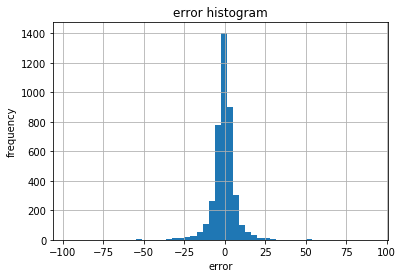

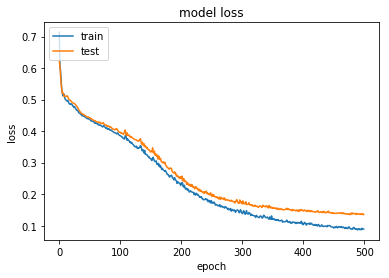

,0
count,4125.000000
mean,-0.378664
std,8.050457
min,-96.378191
25%,-3.270789
50%,-0.296344
75%,2.697134
max,91.645017


In [12]:
def ai_errors(predictions, observations, history = None) :
    '''
    PURPOSE: Provide descriptive statistics on the predicted output versus the observed measurments
    METHOD:  Take the errors of the predictions and answers and then calculate standard descriptive statistics
    INPUT:   predictions - 2D array of predictions of observed output
             observations - 2D array measurements of observed output
             history - Keras history model for displaying model loss, default is None if not available
    OUTPUT:
    '''
    errors = []
    for i in range(len(predictions)) :
        for j in range(len(predictions[i])) :
            # Calculate errors
            error = predictions[i][j] - observations[i][j]
            errors.append(error)
    
    # Display history and erros
    plt.figure(1)
    plt.hist(errors, bins = 50)
    plt.title('error histogram')
    plt.xlabel('error')
    plt.ylabel('frequency')
    plt.grid(True)
    
    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return pd.DataFrame(errors)

# Predict values
wind_predictions = model_wind.predict(X_test)
lat_predictions = model_lat.predict(X_test)
long_predictions = model_long.predict(X_test)

# Scale back our predictions
# Wind
wind_predictions_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0] for winds in prediction])
                           for prediction in wind_predictions]
y_wind_test_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0] for winds in observation])
                      for observation in y_test_wind]
# Latitude
lat_predictions_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0] for lat in prediction])
                          for prediction in lat_predictions]
y_lat_test_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0] for lat in observation])
                     for observation in y_test_lat]
# Longitude
long_predictions_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0] for long in prediction])
                           for prediction in long_predictions]
y_long_test_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0] for long in observation])
                      for observation in y_test_long]

# Record wind predictions and observations
print("Wind")
wind_predictions = [[pred[2] for pred in hurricanes_pred] for hurricanes_pred in wind_predictions_scaled]
wind_observations = [[obsrv[2] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_wind_test_scaled]

# Present Errors
ai_errors(wind_predictions, wind_observations, model_wind_history).describe()

Lat


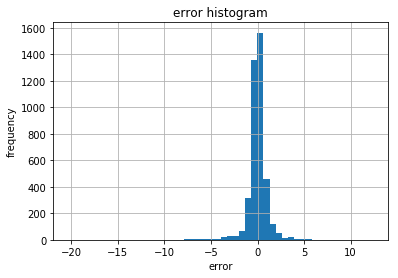

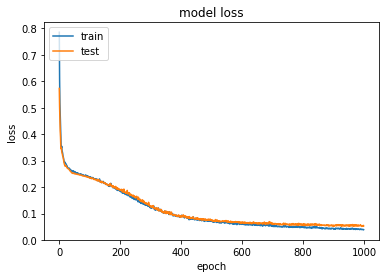

,0
count,4125.000000
mean,0.019501
std,1.351134
min,-20.295284
25%,-0.325692
50%,0.053342
75%,0.437728
max,12.411461


In [13]:
print("Lat")
lat_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in lat_predictions_scaled]
lat_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_lat_test_scaled]
ai_errors(lat_predictions, lat_observations, model_lat_history).describe()

Long


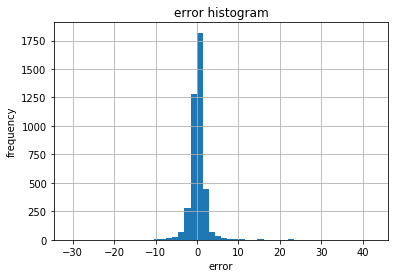

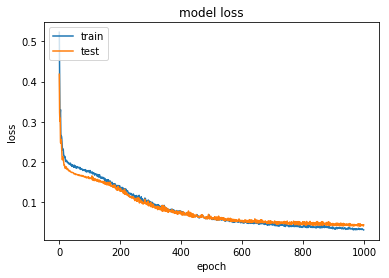

,0
count,4125.000000
mean,0.135158
std,2.300875
min,-30.939977
25%,-0.659186
50%,0.123691
75%,0.839209
max,42.489526


In [14]:
print("Long")
long_predictions = [[pred[1] for pred in hurricanes_pred] for hurricanes_pred in long_predictions_scaled]
long_observations = [[obsrv[1] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_long_test_scaled]
ai_errors(long_predictions, long_observations, model_long_history).describe()

## Model Evaluation & Benchmarks<a id="Benchmarks"></a>

The machine learning neural network will use 2 main methods of applied evaluation. The first will be evaluated compared to the other models that predict Atlantic hurricanes. The forecast errors have been loaded into each hurricane object corresponding to their forecast model; both the OFCL (official track, or the truth) and the BCD5 (model using multivariate regression). The BCD5 model is "the CLP5 (track) and DSF5 (intensity) models merged" that uses the best track as input.